# Diabetes regression training vs validation loss

In [64]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [65]:
d = load_diabetes()
len(d.data)

442

In [66]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [67]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [68]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [69]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 439.40 validation MSE 3616.04


In [70]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Train network with increasingly sophisticated train method

### Most basic network training; just track training loss

In [71]:
def train0(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()

In [72]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

train0(model, X_train, X_test, y_train, y_test,
       learning_rate=.1, nepochs=1000)

Epoch    0 MSE train loss    29357.418
Epoch  100 MSE train loss     2332.020
Epoch  200 MSE train loss     1832.786
Epoch  300 MSE train loss     1137.299
Epoch  400 MSE train loss      739.554
Epoch  500 MSE train loss      569.274
Epoch  600 MSE train loss      573.837
Epoch  700 MSE train loss      412.220
Epoch  800 MSE train loss      367.237
Epoch  900 MSE train loss      275.760
Epoch 1000 MSE train loss      248.740


### Track validation loss and compare with plot, demonstrate overfitting

In [73]:
def train1(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

In [74]:
def plot_history(history, ax=None, maxy=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_accur))
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

Epoch    0 MSE train loss    29288.627   test loss    28078.039
Epoch  100 MSE train loss     2385.188   test loss     3243.624
Epoch  200 MSE train loss     1954.063   test loss     3395.056
Epoch  300 MSE train loss     1248.674   test loss     3679.390
Epoch  400 MSE train loss      798.826   test loss     4250.103
Epoch  500 MSE train loss      534.775   test loss     4517.700
Epoch  600 MSE train loss      383.986   test loss     4884.408
Epoch  700 MSE train loss      318.821   test loss     5410.662
Epoch  800 MSE train loss      279.463   test loss     5704.252
Epoch  900 MSE train loss      189.837   test loss     5956.520
Epoch 1000 MSE train loss      139.180   test loss     6149.857


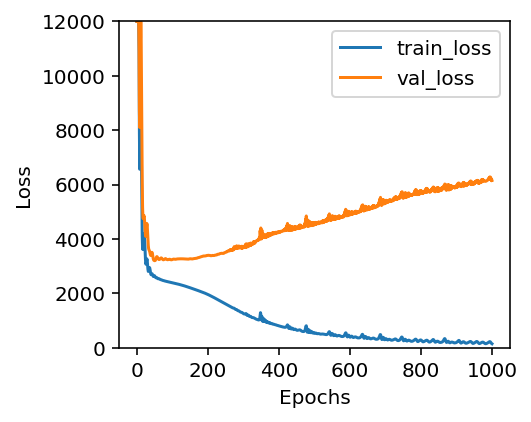

In [75]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history = train1(model, X_train, X_test, y_train, y_test,
                 learning_rate=.1, nepochs=1000)

plot_history(torch.clamp(history, 0, 12000))

### Use weight decay to reduce overfitting

In [76]:
def train2(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0, trace=True):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

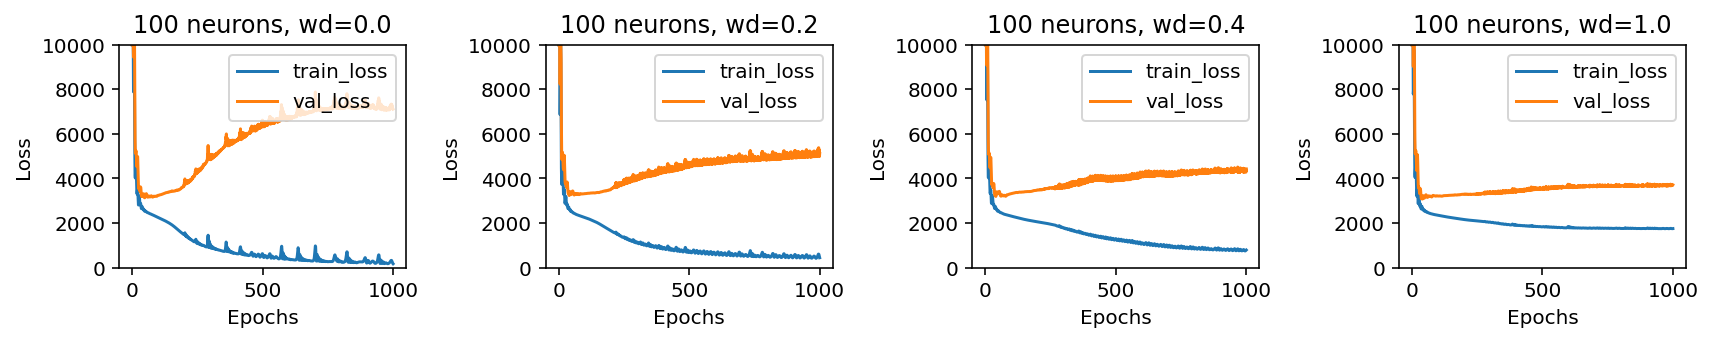

In [77]:
ncols = X.shape[1]
n_neurons = 100

fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

for wd,ax in zip([0,.2,.4,1],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 1)
    )
    history = train2(model, X_train, X_test, y_train, y_test,
                     learning_rate=.15, nepochs=1000, weight_decay=wd,
                     trace=False)
    ax.set_title(f"{n_neurons} neurons, wd={wd:.1f}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()

### Track best loss, model; crank up neurons and stop early

In [78]:
def train3(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    29215.893   test loss    28005.225
Epoch  300 MSE train loss     4919.326   test loss     6290.892
Epoch  600 MSE train loss     3039.046   test loss     4213.760
Epoch  900 MSE train loss     2615.880   test loss     3602.929
Epoch 1200 MSE train loss     2477.262   test loss     3430.310
Epoch 1500 MSE train loss     2402.267   test loss     3384.736
Epoch 1800 MSE train loss     2348.961   test loss     3384.851
Epoch 2100 MSE train loss     2304.243   test loss     3403.572
Epoch 2400 MSE train loss     2267.084   test loss     3418.624
Epoch 2700 MSE train loss     2234.278   test loss     3454.809
Epoch 3000 MSE train loss     2206.456   test loss     3476.926
BEST MSE test loss 3380.024
MSE test loss 3380.024


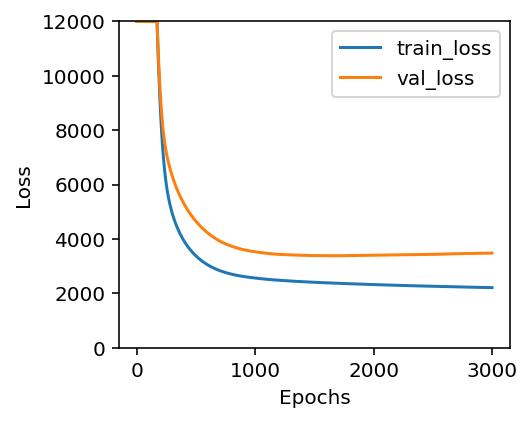

In [81]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train3(model, X_train, X_test, y_train, y_test,
                             learning_rate=.0015, nepochs=3000,
                             weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))

## Batch normalization

Just as we normalize or standardize the input variables, networks train better if we normalize the output of each layer's activation. These activations are the input to the next layer. In this way we normalize the input to every layer.

Epoch    0 MSE train loss    29368.549   test loss    28156.225
Epoch  200 MSE train loss    13294.003   test loss    13065.381
Epoch  400 MSE train loss     3239.748   test loss     3586.227
Epoch  600 MSE train loss     2276.125   test loss     2961.538
Epoch  800 MSE train loss     2193.625   test loss     3025.693
Epoch 1000 MSE train loss     2157.771   test loss     3066.543
Epoch 1200 MSE train loss     2133.064   test loss     3105.101
Epoch 1400 MSE train loss     2112.104   test loss     3146.574
Epoch 1600 MSE train loss     2099.696   test loss     3160.617
Epoch 1800 MSE train loss     2087.266   test loss     3182.066
Epoch 2000 MSE train loss     2075.816   test loss     3212.975
BEST MSE test loss 2953.347
MSE test loss 2953.347


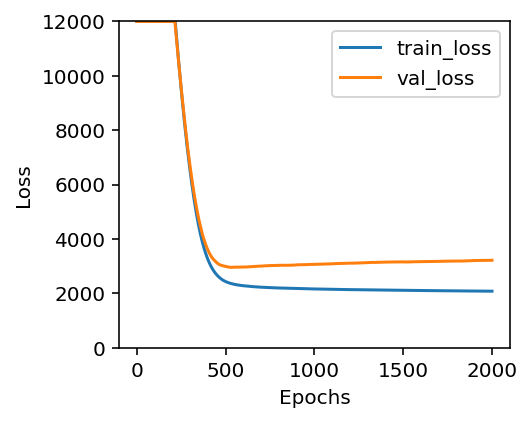

In [82]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train3(model, X_train, X_test, y_train, y_test,
                             learning_rate=.0015, nepochs=2000,
                             weight_decay=.1)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))